# Propagation use-case

In [1]:
import numpy as np
from numpy import exp, pi
from matplotlib import pyplot as plt

from blocksim.control.SetPoint import Step, Ramp
from blocksim.dsp.DSPSignal import DSPSignal
from blocksim.graphics import plotDSPLine, plotGraph
from blocksim.Simulation import Simulation

from blocksim.constants import c, Req
from blocksim.dsp.DSPChannel import DSPChannel

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.XlsLogger
[INFO] - Registered blocksim_logger_rest.PsqlLogger


We define the TX trajectory:

* constant velocity of 2,119.85 m/s on Y, 0 on X and Z
* initial position of -211,985.28 km on Y and Req+211,985.28 km on X

In [2]:
vel0 = np.zeros(6)
vel0[1] = 2119.85
pv0 = np.zeros(6)
pv0[0] = Req + 211985.28
pv0[1] = -211985.28
pv0[3:] = vel0[:3]

tx = Ramp(name="tx", snames=["px", "py", "pz", "vx", "vy", "vz"], slopes=vel0)
tx.setInitialStateForOutput(initial_state=pv0, output_name="setpoint")

The receiver (RX) is fixed on the ground at (Req, 0, 0)

In [3]:
rx = Step(
    name="rx",
    snames=["px", "py", "pz", "vx", "vy", "vz"],
    cons=np.array([Req, 0, 0, 0, 0, 0]),
)

We set a gaussian propagation channel

In [4]:
chn = DSPChannel(
    name="chn",
    wavelength=c / 2e9,
    antenna_gain=0.0,
    antenna_temp=290.0,
    bandwidth=1e6,
    noise_factor=2.5,
    alpha=[0.3820e-7, 0.1490e-7, -0.1790e-6, 0.0000],
    beta=[0.1430e6, 0.0000, -0.3280e6, 0.1130e6],
    noatm=True,
)

We define a signal emitted by TX:

* pure wave of 5 kHz
* emission from t = 0 s to t = 1 ms
* sampled at 100 kHz

In [5]:
f0 = 5e3
fs = 100e3
tps = np.arange(100 * 5) / fs
x = exp(1j * 2 * pi * f0 * tps) * 100
inok = np.where(tps > 1e-3)[0]
x[inok] = 0.0
sig = DSPSignal.fromTimeAndSamples(name="sig", tps=tps, y_serie=x)

We simulate the setup

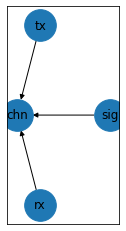

In [6]:
sim = Simulation(sig, tx, chn, rx)

sim.connect("sig.setpoint", "chn.txsig")
sim.connect("tx.setpoint", "chn.txpos")
sim.connect("rx.setpoint", "chn.rxpos")

g = sim.computeGraph()
plotGraph(g)

sim.simulate(tps, progress_bar=False)
log = sim.getLogger()

We get the received signal, and compute its FFT

In [7]:
rxsig = log.getSignal("chn_rxsig_y")
sp = rxsig.fft()

We plot the signal and its FFT

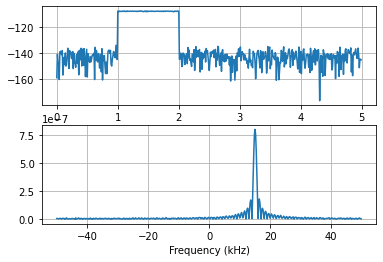

In [8]:
fig = plt.figure()
axe = fig.add_subplot(211)
axe.grid(True)
_ = plotDSPLine(rxsig, axe, transform=rxsig.to_db_lim(-200))

axe = fig.add_subplot(212)
axe.grid(True)
_ = plotDSPLine(sp, axe)